# Mixed ANOVA Test

> Use Case:
- Evaluating the impact of two categorical independent variables (Factors A and B) on a continuous dependent variable.
- Assessing interactions between Factor A and Factor B, as well as their individual effects.

> Assumptions:
1. Normality: The residuals are normally distributed.
2. Homogeneity of Variances: The variances of the residuals are constant across all levels of the factors.
3. Independence: Observations are independent of each other.

> Example Scenario (A/B/C/D Test):
- Factors:
  - Factor A (e.g., Different Versions of a Website)
  - Factor B (e.g., Time of Day)
- Dependent Variable: Continuous metric (e.g., User Engagement)

> Null Hypothesis (H0):
- There is no significant difference in the means of the dependent variable across different levels of Factor A, Factor B, or their interaction.

> Alternative Hypothesis (H1):
- At least one of the means of the dependent variable is different across different levels of Factor A, Factor B, or their interaction.

> Interpretation:
- If the p-value is below the chosen significance level (e.g., 0.05), reject the null hypothesis.
- Significant p-values indicate that there is evidence of a significant difference in means, either due to Factor A, Factor B, or their interaction.

> When to Use:
- When there are two categorical independent variables (Factors A and B) influencing a continuous dependent variable.
- Useful for investigating main effects and interaction effects simultaneously.

In [94]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install statsmodels==0.12.2
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import multipletests

# !pip install scipy==1.12.0
from scipy.stats import probplot, ttest_rel

# !pip install pingouin==0.5.5
import pingouin as pg

In [96]:
# Set random seed for reproducibility
np.random.seed(42)

In [97]:
# set seaborn style
sns.set(style="white", palette="mako")

# colors
color = 'olivedrab'

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Power Analysis

In [98]:
# Define parameters for the power analysis (for the within-subjects factor)
alpha = 0.05
power = 0.80
num_repetitions = 3  # Number of repeated measures (Survey 1, Survey 2, Survey 3)
correlation = 0.5  # Estimated correlation between repeated measures

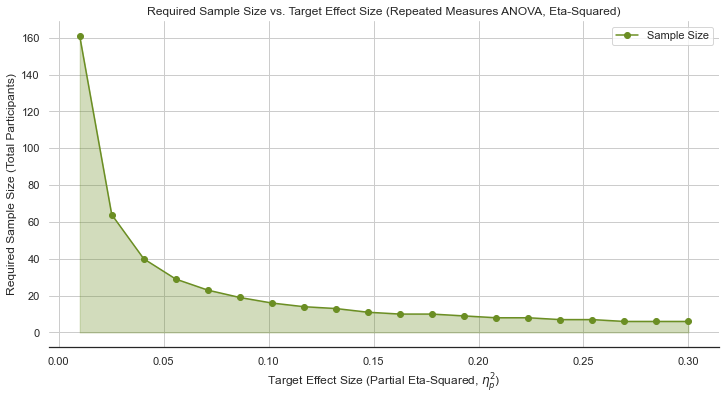

In [99]:
# Define a range of effect sizes (eta-squared) to explore
effect_sizes_eta_sq = np.linspace(0.01, 0.3, 20) # From small to medium-large eta-squared

# Initialize an empty list to store the calculated sample sizes
sample_sizes = []

# Iterate over the effect sizes and calculate the required sample size for each
for eta_sq in effect_sizes_eta_sq:
    # Perform power analysis to calculate sample size for repeated measures ANOVA
    n = pg.power_rm_anova(eta_squared=eta_sq, alpha=alpha, power=power, m=num_repetitions, corr=correlation)
    if not np.isnan(n):
        sample_sizes.append(int(np.ceil(n))) # Round up to the nearest whole number
    else:
        sample_sizes.append(np.nan) # Append NaN if calculation fails

# Plot the effect sizes (eta-squared) against the required sample sizes
plt.figure(figsize=(12, 6))
plt.plot(effect_sizes_eta_sq, sample_sizes, marker='o', linestyle='-', color=color, label='Sample Size')
plt.fill_between(effect_sizes_eta_sq, sample_sizes, color=color, alpha=0.3)
plt.title('Required Sample Size vs. Target Effect Size (Repeated Measures ANOVA, Eta-Squared)')
plt.xlabel('Target Effect Size (Partial Eta-Squared, $\\eta_p^2$)')
plt.ylabel('Required Sample Size (Total Participants)')
plt.grid(True)
plt.legend()
plt.show()

In [100]:
# Calculate required sample size
sample_size_per_group = pg.power_rm_anova(eta_squared=0.01, m=3, power=0.8)

# Round up
sample_size_per_group = int(np.ceil(sample_size_per_group))

print(f"Required sample size per Group: {sample_size_per_group}")


Required sample size per Group: 161


### Synthetic Data

In [ ]:
# Define the levels of the factors
time_points = ['2023', '2024', '2025']
experience_levels = ['Novice', 'Experienced']

# Create empty lists to store the data
data = []
participant_ids = []

# Generate data for each participant
for i in range(1, sample_size_per_group + 1):
    experience = np.random.choice(experience_levels)
    participant_ids.append(f'P{i}')
    for time_index, time in enumerate(time_points):
        # Simulate baseline satisfaction with a clear difference between groups
        baseline_novice = np.random.normal(loc=5, scale=1)
        baseline_experienced = np.random.normal(loc=8, scale=1)

        if experience == 'Novice':
            base_satisfaction = baseline_novice
            # Simulate a more pronounced linear decrease for novices w/ increasing variance over time
            satisfaction = np.random.normal(loc=base_satisfaction - time_index * 1.0, scale=1.2 + time_index * 0.2)
        else:  # Experienced
            base_satisfaction = baseline_experienced
            # Simulate a more pronounced linear increase for experienced users w/ decreasing variance over time
            satisfaction = np.random.normal(loc=base_satisfaction + time_index * 0.8, scale=0.8 - time_index * 0.1) 

        data.append([f'P{i}', experience, time, satisfaction])

# Create the Pandas DataFrame
mixed_anova_df = pd.DataFrame(data, columns=['User_ID', 'Experience_Level', 'Survey_Year', 'Satisfaction_Score'])

mixed_anova_df

,User_ID,Experience_Level,Survey_Year,Satisfaction_Score
0,P1,Novice,2023,5.018399
1,P1,Novice,2024,5.194644
2,P1,Novice,2025,1.617165
3,P2,Novice,2023,3.440612
4,P2,Novice,2024,-0.228949
...,...,...,...,...
478,P160,Experienced,2024,10.557512
479,P160,Experienced,2025,8.670879
480,P161,Novice,2023,7.122840
481,P161,Novice,2024,4.530147


In [102]:
# Display the value counts for the categorical variables to check balance
print(mixed_anova_df['Experience_Level'].value_counts())

Experience_Level
Experienced    249
Novice         234
Name: count, dtype: int64


In [103]:
print(mixed_anova_df['Survey_Year'].value_counts())

Survey_Year
2023    161
2024    161
2025    161
Name: count, dtype: int64


### Assumptions

In [104]:
# 1. Normality of Residuals
print("1. Normality of Residuals: \n")
model = smf.mixedlm("Satisfaction_Score ~ C(Experience_Level) * C(Survey_Year)",
                    mixed_anova_df,
                    groups=mixed_anova_df['User_ID']).fit()
residuals = model.resid

# Shapiro-Wilk Test (good for smaller to moderate sample sizes)

shapiro_test = pg.normality(residuals, method='shapiro', alpha=0.05)

print(f"   Shapiro-Wilk Test: Statistic = {shapiro_test.W[0]:.3f}, p-value = {shapiro_test.pval[0]:.3f}")

if shapiro_test.normal[0]:
    print("   Shapiro-Wilk test suggests residuals are likely normally distributed.")
else:
    print("   Warning: Shapiro-Wilk test suggests residuals may not be normally distributed.")

1. Normality of Residuals: 

   Shapiro-Wilk Test: Statistic = 0.998, p-value = 0.799
   Shapiro-Wilk test suggests residuals are likely normally distributed.


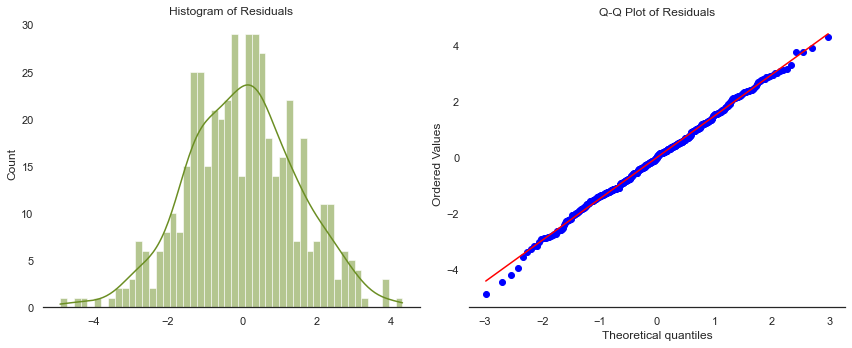

In [105]:
# Visual Inspection: Histogram and Q-Q Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color = color, bins=50)
plt.title("Histogram of Residuals")
plt.subplot(1, 2, 2)
probplot(residuals, plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

In [ ]:
print("2. Homogeneity of Variances (Between-Subjects):\n")

# Create a single DataFrame in long format for pingouin
data_for_homoscedasticity = pd.DataFrame({'residuals': residuals,
                                        'Experience_Level': mixed_anova_df['Experience_Level']})

if data_for_homoscedasticity['Experience_Level'].nunique() >= 2:
    levene_test = pg.homoscedasticity(data_for_homoscedasticity,
                                    dv='residuals',
                                    group='Experience_Level',
                                    method='levene')

    print(f"   Levene's Test: Statistic = {levene_test['W'][0]:.3f}, p-value = {levene_test['pval'][0]:.3f}")
    if levene_test['equal_var'][0]:
        print("   Levene's test suggests equal variances across experience levels.")
    else:
        print("   Warning: Levene's test suggests unequal variances across experience levels.")
else:
    print("   Warning: Less than two levels found for the between-subjects factor. Cannot perform Levene's test.")

2. Homogeneity of Variances (Between-Subjects):

   Levene's Test: Statistic = 9.938, p-value = 0.002


In [107]:
# 3. Sphericity (using pingouin)
print("3. Sphericity (Homogeneity of Variances of Differences - Within-Subjects):\n")

if len(mixed_anova_df['Survey_Year'].unique()) > 2:
    
    sphericity_test = pg.sphericity(data=mixed_anova_df, dv='Satisfaction_Score', within='Survey_Year', subject='User_ID')
    
    print(f"   Mauchly's Test of Sphericity: W = {sphericity_test.W:.3f}, p-value = {sphericity_test.pval:.3f}, Sphericity Met = {sphericity_test.spher}")
    
    if sphericity_test.pval < 0.05:
        print("   Warning: Mauchly's test suggests a violation of sphericity. Consider using Greenhouse-Geisser or Huynh-Feldt corrections in your Mixed ANOVA.")
    else:
        print("   Mauchly's test suggests sphericity is likely met for the within-subjects factor.")
else:
    print("   Sphericity is not a concern for within-subjects factors with only 2 levels.")

3. Sphericity (Homogeneity of Variances of Differences - Within-Subjects):

   Mauchly's Test of Sphericity: W = 0.990, p-value = 0.445, Sphericity Met = True
   Mauchly's test suggests sphericity is likely met for the within-subjects factor.


### Mixed ANOVA (pingouin)

In [125]:
aov = pg.mixed_anova(data=mixed_anova_df, dv='Satisfaction_Score', within='Survey_Year', between='Experience_Level', subject='User_ID', correction=True)
aov.round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,Experience_Level,2853.637,1,159,2853.637,1352.159,0.000,NaN,0.895,NaN,NaN,NaN,NaN
1,Survey_Year,12.658,2,318,6.329,2.793,0.063,0.118,0.017,0.99,True,0.99,0.445
2,Interaction,218.358,2,318,109.179,48.183,0.000,NaN,0.233,NaN,NaN,NaN,NaN


### Mixed ANOVA (statsmodels)

In [109]:
# Specify the mixed-effects model formula
formula = f"Satisfaction_Score ~ C(Experience_Level) * C(Survey_Year)"

# Fit the linear mixed-effects model with subject as the random effect
mixed_anova_model = smf.mixedlm(formula, data=mixed_anova_df, groups=mixed_anova_df['User_ID']).fit()

mixed_anova_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
================================================================================================
Model:                        MixedLM           Dependent Variable:           Satisfaction_Score
No. Observations:             483               Method:                       REML              
No. Groups:                   161               Scale:                        2.2141            
Min. group size:              3                 Log-Likelihood:               -879.5670         
Max. group size:              3                 Converged:                    Yes               
Mean group size:              3.0                                                               
------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                             8.088    0.163  49.522 0.000  7.768  8.408
C(Experience_Level)[T.Novice]                        -3.296    0.235 -14.047 0.000 -3.756 -2.836
C(Survey_Year)[T.2024]                                0.845    0.231   3.660 0.000  0.393  1.298
C(Survey_Year)[T.2025]                                1.356    0.231   5.872 0.000  0.904  1.809
C(Experience_Level)[T.Novice]:C(Survey_Year)[T.2024] -1.417    0.332  -4.270 0.000 -2.068 -0.767
C(Experience_Level)[T.Novice]:C(Survey_Year)[T.2025] -3.285    0.332  -9.900 0.000 -3.936 -2.635
Group Var                                             0.000    0.072                            
================================================================================================

"""

In [110]:
print("P-values for Fixed Effects (from mixedlm): \n")
print(mixed_anova_model.pvalues.round(3))

P-values for Fixed Effects (from mixedlm): 

Intercept                                               0.0
C(Experience_Level)[T.Novice]                           0.0
C(Survey_Year)[T.2024]                                  0.0
C(Survey_Year)[T.2025]                                  0.0
C(Experience_Level)[T.Novice]:C(Survey_Year)[T.2024]    0.0
C(Experience_Level)[T.Novice]:C(Survey_Year)[T.2025]    0.0
Group Var                                               1.0
dtype: float64


In [111]:
# Example F-tests for main effects (you'll need to adapt the contrasts)
contrast_exp = 'C(Experience_Level)[T.Novice] = 0'
f_test_exp = mixed_anova_model.f_test(contrast_exp)
print("F-test for Experience Level: \n")
print(f_test_exp)

F-test for Experience Level: 

<F test: F=array([[197.32744073]]), p=9.291157613951465e-38, df_denom=477, df_num=1>


### Post-Hoc (SciPy / statsmodels)

In [112]:
# Post-Hoc Tests (Example for between-subjects factor using Tukey's HSD)
m_comp = pairwise_tukeyhsd(mixed_anova_df['Satisfaction_Score'], mixed_anova_df['Experience_Level'], alpha=0.05)
print("Post-Hoc Test (Tukey's HSD) for Experience Level: \n")
print(m_comp)


Post-Hoc Test (Tukey's HSD) for Experience Level: 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
   group1   group2 meandiff p-adj  lower  upper  reject
-------------------------------------------------------
Experienced Novice  -4.8637 0.001 -5.1563 -4.571   True
-------------------------------------------------------


In [113]:
within_levels = mixed_anova_df['Survey_Year'].unique()
between_levels = mixed_anova_df['Experience_Level'].unique()

alpha = 0.05

all_p_values = []
comparisons = []

print(f"Post-Hoc Tests for Survey_Year by Experience_Level (Paired T-tests with Bonferroni): \n")

for bet_level in between_levels:

    subset = mixed_anova_df[mixed_anova_df['Experience_Level'] == bet_level]
    subject_ids = subset['User_ID'].unique()

    for i in range(len(within_levels)):
        for j in range(i + 1, len(within_levels)):

            level_a = within_levels[i]
            level_b = within_levels[j]
            group_a = subset[subset['Survey_Year'] == level_a].pivot(index='User_ID', columns='Survey_Year', values='Satisfaction_Score')[level_a].dropna()
            group_b = subset[subset['Survey_Year'] == level_b].pivot(index='User_ID', columns='Survey_Year', values='Satisfaction_Score')[level_b].dropna()

            if len(group_a) > 0 and len(group_b) > 0:
                ttest_result = ttest_rel(group_a, group_b)
                all_p_values.append(ttest_result.pvalue)
                comparisons.append(f"Experience_Level={bet_level}, Survey_Year={level_a} vs {level_b}")

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(all_p_values, method='bonferroni', alpha=alpha)
for i, comp in enumerate(comparisons):
    print(f"   {comp}: p = {all_p_values[i].round(3)}, p_corrected = {p_corrected[i].round(3)}, Reject = {reject[i]}")



Post-Hoc Tests for Survey_Year by Experience_Level (Paired T-tests with Bonferroni): 

   Experience_Level=Novice, Survey_Year=2023 vs 2024: p = 0.033, p_corrected = 0.199, Reject = False
   Experience_Level=Novice, Survey_Year=2023 vs 2025: p = 0.0, p_corrected = 0.0, Reject = True
   Experience_Level=Novice, Survey_Year=2024 vs 2025: p = 0.0, p_corrected = 0.0, Reject = True
   Experience_Level=Experienced, Survey_Year=2023 vs 2024: p = 0.0, p_corrected = 0.002, Reject = True
   Experience_Level=Experienced, Survey_Year=2023 vs 2025: p = 0.0, p_corrected = 0.0, Reject = True
   Experience_Level=Experienced, Survey_Year=2024 vs 2025: p = 0.018, p_corrected = 0.106, Reject = False


### Post-Hoc (pingouin)

In [114]:
# Perform post-hoc tests based on significant main effects or interaction
alpha = 0.05

In [115]:
# Post-hoc for the between-subjects factor if significant
if 'Experience_Level' in aov['Source'].values and aov.loc[aov['Source'] == 'Experience_Level', 'p-unc'].iloc[0] < alpha:
    posthoc_between = pg.pairwise_tukey(data=mixed_anova_df, dv='Satisfaction_Score', between='Experience_Level')
    if posthoc_between is not None:
        display(posthoc_between.round(3))

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Experienced,Novice,8.822,3.958,4.864,0.149,32.656,0.0,2.969


In [116]:
# Post-hoc for the within-subjects factor if significant
if 'Survey_Year' in aov['Source'].values and aov.loc[aov['Source'] == 'Survey_Year', 'p-unc'].iloc[0] < alpha:
    posthoc_within = pg.pairwise_tukey(data=mixed_anova_df, dv='Satisfaction_Score', within='Survey_Year', subject='User_ID', parametric=True, correction='bonf')
    if posthoc_within is not None:
        display(posthoc_within)

In [117]:
# Post-hoc for the interaction effect if significant
if 'Interaction' in aov['Source'].values and aov.loc[aov['Source'] == 'Interaction', 'p-unc'].iloc[0] < alpha:
    posthoc_interaction = pg.pairwise_ttests(data=mixed_anova_df, dv='Satisfaction_Score', within='Survey_Year', between='Experience_Level',
                                    subject='User_ID', parametric=True, correction='bonf')
    if posthoc_interaction is not None:
        display(posthoc_interaction)

,Contrast,Survey_Year,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,Survey_Year,-,2023,2024,True,True,-0.873038,160.0,two-sided,3.839508e-01,0.128,-0.063089
1,Survey_Year,-,2023,2025,True,True,1.185509,160.0,two-sided,2.375740e-01,0.175,0.078465
2,Survey_Year,-,2024,2025,True,True,2.052117,160.0,two-sided,4.178783e-02,0.678,0.121063
3,Experience_Level,-,Experienced,Novice,False,True,36.771717,159.0,two-sided,1.203077e-79,4.495e+75,5.771436
4,Survey_Year * Experience_Level,2023,Experienced,Novice,False,True,14.815890,159.0,two-sided,9.349868e-32,2.068e+28,2.325400
5,Survey_Year * Experience_Level,2024,Experienced,Novice,False,True,19.571620,159.0,two-sided,3.387574e-44,3.671e+40,3.071827
6,Survey_Year * Experience_Level,2025,Experienced,Novice,False,True,27.401228,159.0,two-sided,4.126034e-62,1.887e+58,4.300708


### Post-Hoc Power Analysis

In [118]:
# Calculate power for a repeated measures ANOVA
power = pg.power_rm_anova(eta_squared=0.1, m=3, n=len(mixed_anova_df))
print(f"Power: {power:.4f}")


Power: 1.0000


### Visualization

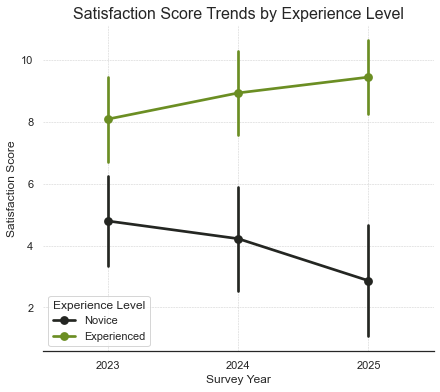

In [121]:
plt.figure(figsize = (7, 6))
sns.pointplot(data=mixed_anova_df,
                x='Survey_Year',
                y='Satisfaction_Score',
                hue='Experience_Level', 
                ci='sd', 
                markers=['o', 'o'], 
                linestyles = ['-', '-'], color = color )
plt.title('Satisfaction Score Trends by Experience Level', fontsize=16)
plt.xlabel('Survey Year')
plt.ylabel('Satisfaction Score')
plt.legend(title='Experience Level', loc='lower left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()